In [1]:
## Import libraries and enable GPU in tensorflow

import tensorflow as tf
try:
    physical_devices = tf.config.list_physical_devices('GPU')
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    pass

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [2]:
# Import libraries

import pathlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

In [3]:
# Define the dataset path

data_dir = "./dogImages/train"
print(data_dir)

./dogImages/train


In [4]:
# Degine some parameter
img_height = 224
img_width = 224
batch_size = 1 ## Images will pass into the network per epochs

# Load images into the train dataloader
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  "./dogImages/train",
  labels='inferred',
  label_mode='categorical',
  # validation_split=0.2, #use 80% as training dataset
  # subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size
)

class_names = train_ds.class_names

Found 6680 files belonging to 133 classes.


In [5]:
# Degine some parameter
img_height = 224
img_width = 224
batch_size = 1 ## Images will pass into the network per epochs

# Load images into the validation dataloader
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  "./dogImages/valid",
  labels='inferred',
  label_mode='categorical',
  # validation_split=0.2, #use 20% as training dataset
  # subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size
)

class_names = val_ds.class_names

Found 829 files belonging to 133 classes.


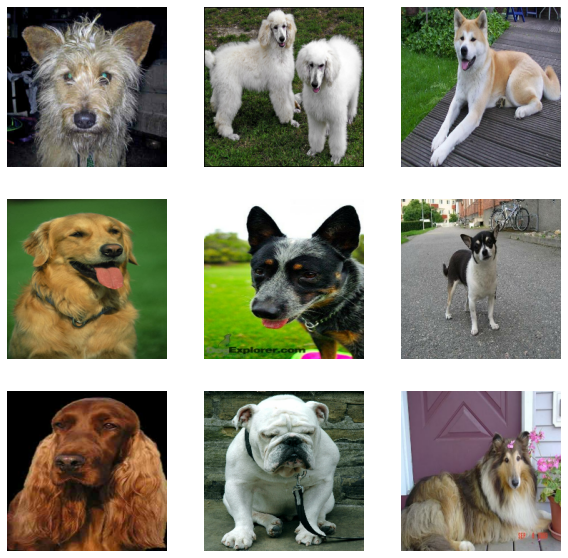

In [6]:
# Show images to make sure images loaded are correct

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
#         plt.title(class_names[labels[i]])
        plt.axis("off")

In [7]:
# Check the dataloader parameter

for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(64, 224, 224, 3)
(64, 133)


In [8]:
# Normalize the images
## normal images => 0-255
## normalized images => 0-1

## example:
## 127 in normal image === 0.5 in normalized image

## we normalize images to reduce the computation cost.

normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))

0.0025211112 1.0


In [9]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [10]:
# create the base model
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

base_model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False)
base_model

In [11]:
# freeze layers -> we train again from scratch
for layer in base_model.layers[:143]:
    layer.trainable = False

# let's visualize layer names and layer indices to see how many layers
# we should freeze:
for i, layer in enumerate(base_model.layers):
       print(i, layer.name, "-", layer.trainable)

0 input_1 - False
1 conv1_pad - False
2 conv1_conv - False
3 conv1_bn - False
4 conv1_relu - False
5 pool1_pad - False
6 pool1_pool - False
7 conv2_block1_1_conv - False
8 conv2_block1_1_bn - False
9 conv2_block1_1_relu - False
10 conv2_block1_2_conv - False
11 conv2_block1_2_bn - False
12 conv2_block1_2_relu - False
13 conv2_block1_0_conv - False
14 conv2_block1_3_conv - False
15 conv2_block1_0_bn - False
16 conv2_block1_3_bn - False
17 conv2_block1_add - False
18 conv2_block1_out - False
19 conv2_block2_1_conv - False
20 conv2_block2_1_bn - False
21 conv2_block2_1_relu - False
22 conv2_block2_2_conv - False
23 conv2_block2_2_bn - False
24 conv2_block2_2_relu - False
25 conv2_block2_3_conv - False
26 conv2_block2_3_bn - False
27 conv2_block2_add - False
28 conv2_block2_out - False
29 conv2_block3_1_conv - False
30 conv2_block3_1_bn - False
31 conv2_block3_1_relu - False
32 conv2_block3_2_conv - False
33 conv2_block3_2_bn - False
34 conv2_block3_2_relu - False
35 conv2_block3_3_conv - 

In [12]:
import tensorflow.keras as K

# this is the model we will train
model = K.models.Sequential()
model.add(K.layers.Lambda(lambda image: tf.image.resize(image, (224, 224))))
model.add(base_model)
model.add(K.layers.Flatten())
model.add(K.layers.BatchNormalization())
model.add(K.layers.Dense(256, activation='relu'))
model.add(K.layers.Dropout(0.5))
model.add(K.layers.BatchNormalization())
model.add(K.layers.Dense(128, activation='relu'))
model.add(K.layers.Dropout(0.5))
model.add(K.layers.BatchNormalization())
model.add(K.layers.Dense(64, activation='relu'))
model.add(K.layers.Dropout(0.5))
model.add(K.layers.BatchNormalization())
model.add(K.layers.Dense(133, activation='softmax')) # 3 is number of output

In [13]:
# we use SGD with a low learning rate
from tensorflow.keras.optimizers import SGD
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy']) # Define optimizer/LR

In [14]:
EPOCHS = 1 # number of cycle

## Only save best model, check using validation accuracy
checkpoint_filepath = 'checkpoints'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [15]:
# start training
history = model.fit(train_ds, validation_data=val_ds,
          epochs=EPOCHS, callbacks=[model_checkpoint_callback])

 89/105 [========================>.....] - ETA: 56s - loss: 5.1677 - accuracy: 0.0067

InvalidArgumentError:  jpeg::Uncompress failed. Invalid JPEG data or crop window.
	 [[{{node decode_image/DecodeImage}}]]
	 [[IteratorGetNext]] [Op:__inference_train_function_12913]

Function call stack:
train_function


In [ ]:
# define the temperaty folder to save the best model
model.load_weights(checkpoint_filepath)